In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
import tensorflow as tf
print(tf.__version__)


2.19.0


In [ ]:
import os
import numpy as np
import pandas as pd

In [5]:

train_dataset = '/mnt/c/Users/ASUS/Downloads/archive/DATASET/TRAIN'

if os.path.exists(train_dataset):
        train_wastetypes = os.listdir(train_dataset)
else:
    print("Train Path not found")


In [6]:

train_data = []
for train_wastetype in train_wastetypes:
    for file in os.listdir(os.path.join(train_dataset, train_wastetype)):
        train_data.append((os.path.join(train_dataset, train_wastetype, file), train_wastetype))

df = pd.DataFrame(train_data, columns=['filepath', 'label'])


In [7]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,                     
    rotation_range=45,                  
    width_shift_range=0.15,          
    height_shift_range=0.15,        
    zoom_range=0.15,                
    horizontal_flip=True,           
    vertical_flip=True,        
    shear_range=0.05,               
    brightness_range=[0.9, 1.1],   
    fill_mode='nearest',             
    
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True,
    seed=42
)
print(train_generator.class_indices)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True,  
    seed=42
)

print(test_generator.class_indices)



Found 18051 validated image filenames belonging to 3 classes.
{'N': 0, 'O': 1, 'R': 2}
Found 4513 validated image filenames belonging to 3 classes.
{'N': 0, 'O': 1, 'R': 2}


In [30]:

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2



base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))


for i, layer in enumerate(base_model.layers):
    layer.trainable = i >= len(base_model.layers) - 25


In [46]:
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.regularizers import l2
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.3)(x)
prediction = Dense(3, activation='softmax')(x)

model_1 = Model(inputs=base_model.input, outputs=prediction)


In [ ]:
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
callbacks = EarlyStopping(patience = 5, monitor='val_loss', mode='min')


model_1.compile(optimizer = Adam(learning_rate=0.00003),
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

In [33]:

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(patience=7, monitor='val_accuracy', mode='max', verbose=1)
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='/mnt/c/Users/ASUS/Desktop/best_modelEffecient.keras',       
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,                  
    mode='min',                            
    verbose=1
)



In [34]:

from sklearn.metrics import confusion_matrix


class ConfusionMatrixCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_data):
        super().__init__()
        self.validation_data = val_data

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_true = self.validation_data
        
        y_pred = self.model.predict(x_val, verbose=0)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_true_classes = np.argmax(y_true, axis=1)

        cm = confusion_matrix(y_true_classes, y_pred_classes)
        print(f"\nConfusion Matrix after Epoch {epoch + 1}:")
        print(cm)

x_val, y_val = next(test_generator)


# Initialize the callback
cm_callback = ConfusionMatrixCallback((x_val, y_val))


In [35]:
import math


history = model_1.fit(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples / train_generator.batch_size),
    validation_data=test_generator,
    validation_steps=math.ceil(test_generator.samples / test_generator.batch_size),
    epochs=50,
    callbacks = [cm_callback,reduce_lr, early_stop,checkpoint] ,
    verbose=1
    
);


Epoch 1/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.6493 - loss: 1.3102
Confusion Matrix after Epoch 1:
[[ 3  0  3]
 [ 0 27  4]
 [ 1  2 24]]

Epoch 1: val_loss improved from inf to 0.82014, saving model to /mnt/c/Users/ASUS/Desktop/best_modelEffecient.keras
283/283 ━━━━━━━━━━━━━━━━━━━━ 207s 702ms/step - accuracy: 0.6495 - loss: 1.3096 - val_accuracy: 0.8476 - val_loss: 0.8201 - learning_rate: 3.0000e-05
Epoch 2/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.8043 - loss: 0.9096
Confusion Matrix after Epoch 2:
[[ 5  0  1]
 [ 1 27  3]
 [ 1  2 24]]

Epoch 2: val_loss improved from 0.82014 to 0.77082, saving model to /mnt/c/Users/ASUS/Desktop/best_modelEffecient.keras
283/283 ━━━━━━━━━━━━━━━━━━━━ 188s 665ms/step - accuracy: 0.8043 - loss: 0.9095 - val_accuracy: 0.8635 - val_loss: 0.7708 - learning_rate: 3.0000e-05
Epoch 3/50
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.8348 - loss: 0.8313
Confusion Matrix after Epoch 3:
[[ 5  0  1]
 [ 1 27  3]
 [ 1  

In [36]:
import matplotlib.pyplot as plt

def plot_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)

    # Separate accuracy and loss values
    training_acc = [history.history[key] for key in history.history if 'acc' in key and 'val' not in key]
    validation_acc = [history.history[key] for key in history.history if 'acc' in key and 'val' in key]
    
    training_loss = [history.history[key] for key in history.history if 'loss' in key and 'val' not in key]
    validation_loss = [history.history[key] for key in history.history if 'loss' in key and 'val' in key]

    # Plotting accuracy
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    for acc, label in zip(training_acc, ['Training Accuracy']):
        plt.plot(epochs, acc, 'b', label=f'{label} ({acc[-1]:.5f})')
    for acc, label in zip(validation_acc, ['Validation Accuracy']):
        plt.plot(epochs, acc, 'g', label=f'{label} ({acc[-1]:.5f})')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    for loss, label in zip(training_loss, ['Training Loss']):
        plt.plot(epochs, loss, 'r', label=f'{label} ({loss[-1]:.5f})')
    for loss, label in zip(validation_loss, ['Validation Loss']):
        plt.plot(epochs, loss, 'orange', label=f'{label} ({loss[-1]:.5f})')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


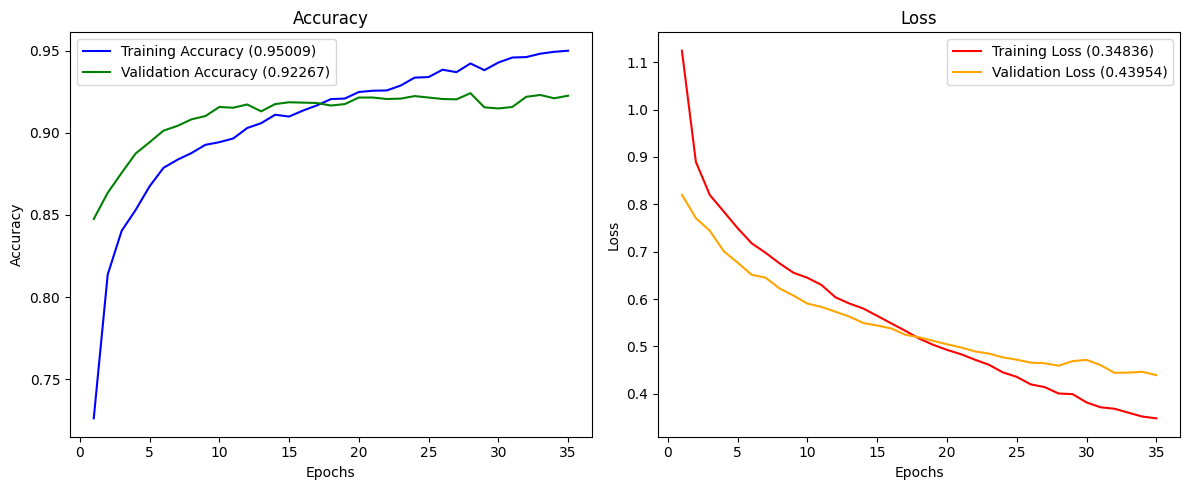

In [37]:
plot_history(history)